In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings('ignore')


/tmp/ipykernel_31878/4180100972.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
save_dir = Path("../../data-cumberland/insitu")
save_dir.mkdir(exist_ok=True)

<AxesSubplot:>

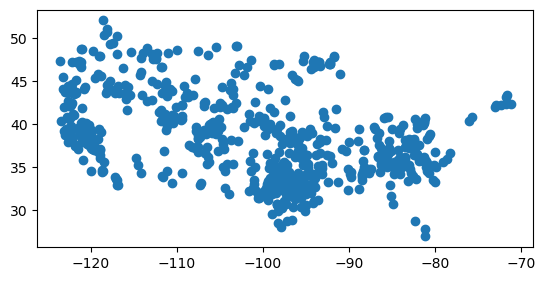

In [4]:
data_directory = Path("../../data-cumberland/ResOpsUS-Cumberland/")
reservoir_attributes_fn = data_directory / "reservoir_attributes.csv"

resops_attributes = pd.read_csv(reservoir_attributes_fn)
resops_attributes['DAM_NAME'] = resops_attributes['DAM_NAME'].str.replace(' ', '_')

resops_attributes = gpd.GeoDataFrame(resops_attributes, geometry=gpd.points_from_xy(x=resops_attributes['LONG'], y=resops_attributes['LAT']))
resops_attributes.plot()

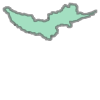

In [5]:
# read the boundary
fn = Path('../../data-cumberland/Cumberland Boundary/Cumberland Boundary.shp')
gdf = gpd.read_file(fn)

gdf.geometry[0]

<GeoAxesSubplot:>

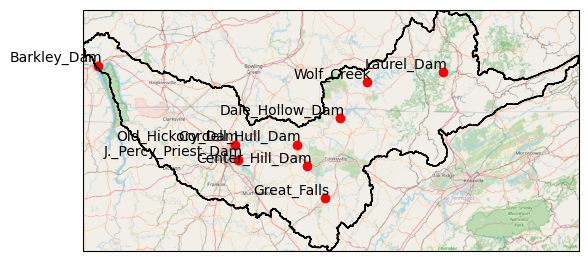

In [9]:
sites_within_basin = resops_attributes[resops_attributes.within(gdf.geometry[0])]

f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

request = cimgt.OSM()
extent = gdf.bounds[['minx', 'maxx', 'miny', 'maxy']].values[0]
ax.set_extent(extent)
ax.add_image(request, 8)

sites_within_basin.plot(ax=ax, color='red')
for x, y, label in zip(sites_within_basin.geometry.x, sites_within_basin.geometry.y, sites_within_basin.DAM_NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", horizontalalignment='right')

gdf.plot(ax=ax, fc='none', label='Cumberland basin boundary')

In [10]:
station_file_fn = Path('../../data-cumberland/cumberland-stations/cumberland-resops-stations.csv')
station_file_fn.parent.mkdir(exist_ok=True)

station_file_fn

PosixPath('../../data-cumberland/cumberland-stations/cumberland-resops-stations.csv')

In [11]:
sites_within_basin.rename({
    'DAM_NAME': 'name',
    'LONG': 'lon',
    'LAT': 'lat'
    }, axis=1, inplace=True)
sites_within_basin['run'] = 1

sites_within_basin[['run', 'name', 'lat', 'lon']].to_csv(station_file_fn, index=False)

Barkley dam falls outside flow direction file, manually move the point to the grid box to its right.